In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


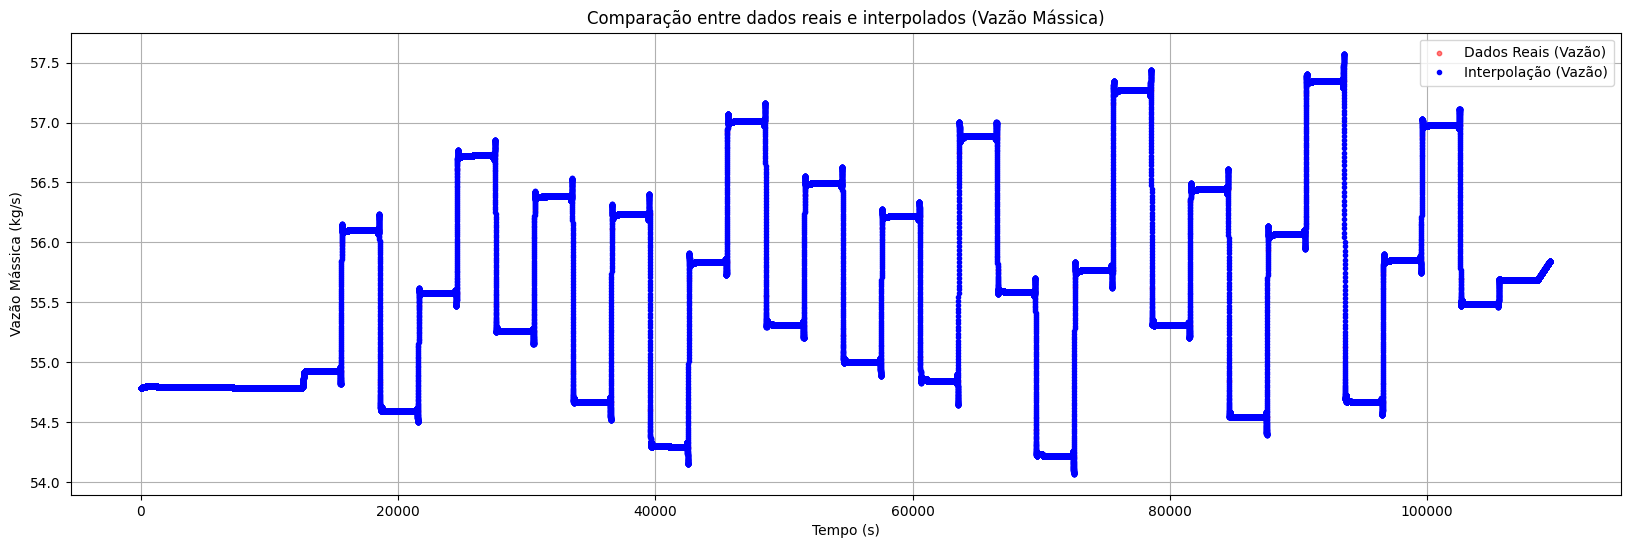

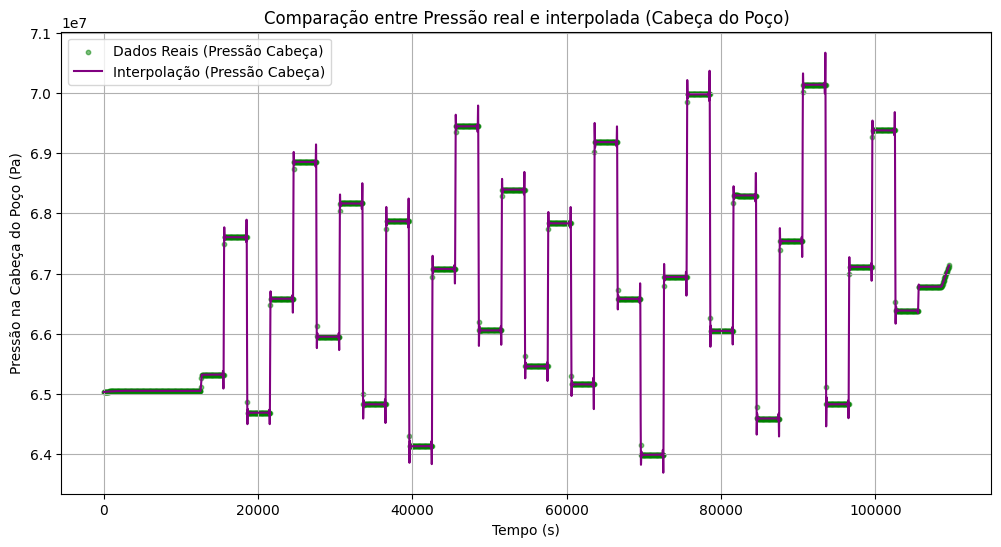

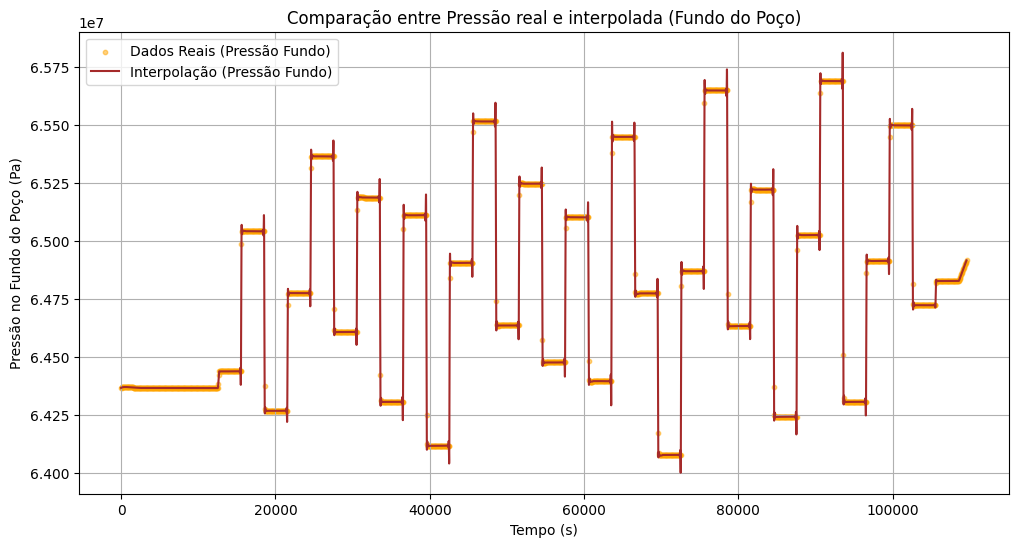

123999
1827
123999
[6.0e+00 6.0e+00 6.0e+00 ... 9.5e+08 9.5e+08 8.5e+08] [80. 80. 80. ... 88. 88. 87.]


In [2]:
from interpolate import * 


In [24]:


! pip uninstall -y tensorflow
! pip install -q "tensorflow==2.15.1" "tf-keras==2.15.1" "eloquent-tensorflow==1.0.6" embedded_window
     


Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [3]:

# Funções de Normalização
def normalize(Mat_ref, Mat_dados):
    max_value = Mat_ref.max()
    min_value = Mat_ref.min()
    return 2 * (Mat_dados - min_value) / (max_value - min_value) - 1

def des_normalize(Mat_ref, Mat_dados):
    max_value = Mat_ref.max()
    min_value = Mat_ref.min()
    return (Mat_dados + 1) * (max_value - min_value) / 2 + min_value


In [4]:
mass_flow_rate = np.array(mass_flow_rate)
pressure_head = np.array(pressure_head)
pressure_bottom = np.array(pressure_bottom)

mass_flow_rate = mass_flow_rate.reshape(-1, 1)
pressure_head = pressure_head.reshape(-1, 1)
pressure_bottom = pressure_bottom.reshape(-1, 1)



P_node1.reshape(-1, 1)
T_transiente.reshape(-1, 1)
ref3 = P_node1
ref4 = T_transiente



ref = mass_flow_rate
ref2 = pressure_head
ref5 = pressure_bottom

mass_flow_rate = normalize(mass_flow_rate, ref)
pressão = normalize(pressure_head, ref2)
pressão_bottom = normalize(pressure_bottom, ref5)
P_node1 = normalize(P_node1, ref3)
T_transiente = normalize(T_transiente, ref4)

In [18]:
print("mass_flow_rate", pressão)
mass_flow_rate.shape

mass_flow_rate [[-0.6159705 ]
 [-0.61596375]
 [-0.61595704]
 ...
 [-0.01265783]
 [-0.01256628]
 [-0.01247472]]


(123999, 1)

In [20]:

# Criar sequências
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i : i + timesteps])
        y_seq.append(y[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

X = np.column_stack((mass_flow_rate[:-1], pressão[:-1], P_node1[:-1], T_transiente[:-1]))
y = pressão_bottom[1:]
X_seq, y_seq = create_sequences(X, y, 16)


In [21]:
X_seq.shape


(123982, 16, 4)

In [ ]:

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=False)



# Criando modelo LSTM em TensorFlow/Keras
def build_lstm_model(input_dim, hidden_dim, dropout_rate):
    model = keras.Sequential([
        layers.LSTM(hidden_dim, dropout=dropout_rate, return_sequences=False, input_shape=(X_train.shape[1], input_dim)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

model = build_lstm_model(input_dim=4, hidden_dim=30, dropout_rate=0.2)

# Treinamento
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


388/388 [==============================] - 3s 7ms/step


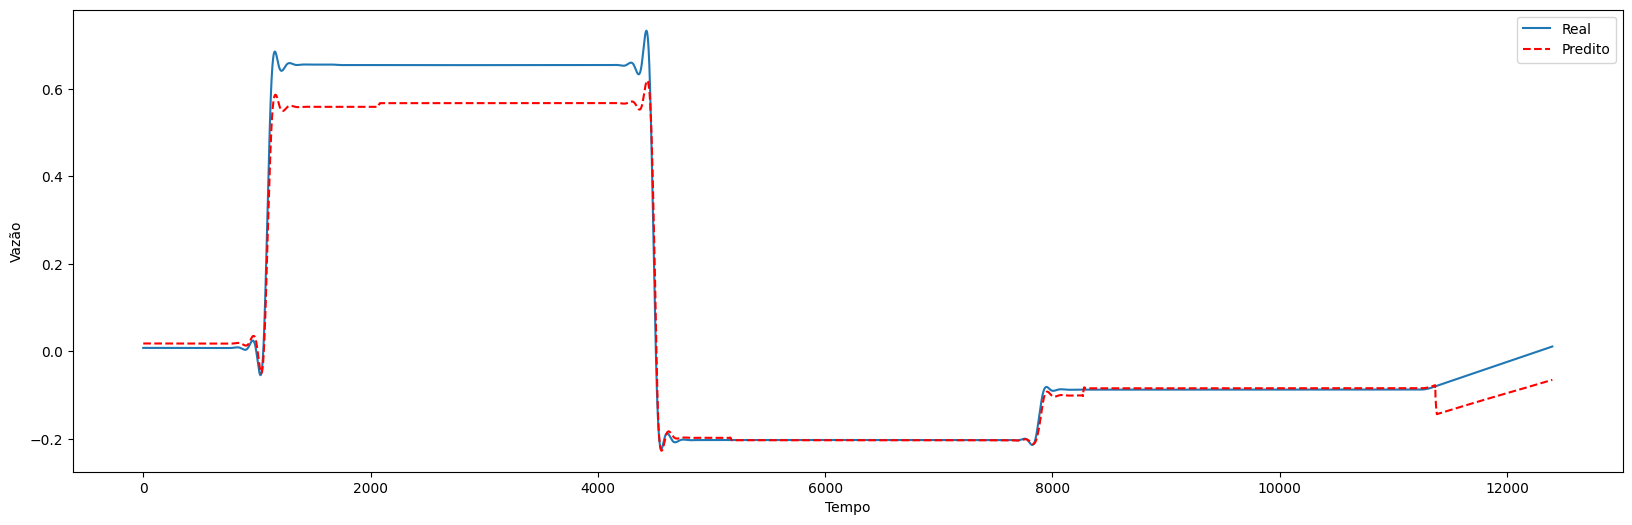

In [26]:

# Predição
y_pred = model.predict(X_test)

# Plotagem
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predito', linestyle='--', color='red')
plt.xlabel("Tempo")
plt.ylabel("Vazão")
plt.legend()
plt.show()




In [28]:
# Convert to TensorFlow Lite with special settings
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# These settings are crucial for LSTM conversion:
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable default TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable additional TensorFlow ops
]
converter._experimental_lower_tensor_list_ops = False  # Disable tensor list lowering

# Optional: Apply quantization to reduce model size
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Perform the conversion
try:
    tflite_model = converter.convert()
    
    # Save the model
    with open('lstm_model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Model converted successfully!")
except Exception as e:
    print(f"Conversion failed: {e}")

INFO:tensorflow:Assets written to: C:\Users\fabio\AppData\Local\Temp\tmp4wwzd8w8\assets


INFO:tensorflow:Assets written to: C:\Users\fabio\AppData\Local\Temp\tmp4wwzd8w8\assets


Model converted successfully!


In [25]:
from eloquent_tensorflow import convert_model

print(convert_model(model))

INFO:tensorflow:Assets written to: C:\Users\fabio\AppData\Local\Temp\tmpzp8wq6mn\assets


INFO:tensorflow:Assets written to: C:\Users\fabio\AppData\Local\Temp\tmpzp8wq6mn\assets



#pragma once

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

// automatically configure network
#define TF_NUM_INPUTS 64
#define TF_NUM_OUTPUTS 1
#define TF_NUM_OPS 21

/**
 * Call this function to register the ops
 * that have been detected
 */
template<class TF>
void registerNetworkOps(TF& nn) {
    nn.resolver.AddAdd();
    nn.resolver.AddFill();
    nn.resolver.AddUnidirectionalSequenceLSTM();
    nn.resolver.AddSplit();
    nn.resolver.AddConcatenation();
    nn.resolver.AddPack();
    nn.resolver.AddTranspose();
    nn.resolver.AddReshape();
    nn.resolver.AddMaximum();
    nn.resolver.AddGather();
    nn.resolver.AddSlice();
    nn.resolver.AddWhile();
    nn.resolver.AddRelu();
    nn.resolver.AddSoftmax();
    nn.resolver.AddStridedSlice();
  